# Tarea5

**Envío del PR inicial:** lunes 17 de octubre

**Aceptación del PR:** lunes 31 de octubre

In [1]:
using Plots, LsqFit, Roots,Polynomials
include("AutomDiff_V2.jl")
import AD: Dual, xdual
using TaylorSeries

**Ejercicio 1:**

Obtengan, para la familia de mapeos cuadrática $Q_c(x)$, el exponente de Lyapunov en términos de $c$.

- ¿Qué particularidad ocurre (en términos del exponente de Lyapunov) para los valores
de $c$ donde hay bifurcaciones?

- ¿Qué particularidad ocurre (en términos del exponente de Lyapunov) cuando tenemos *ciclos superestables*, es decir, cuando $x=0$ es parte de un ciclo periódico?

In [2]:
function iterado(F,x0::Float64,n)
    y = [x0]
    x = x0
    for i in 1:n
        x=F(x)
        push!(y,x)
    end
    y
end

iterado (generic function with 1 method)

In [3]:
Qc(x,c)=x^2+c
Qc1(x) = Qc(x,-1.23)
y=iterado(Qc1,1.0,10)


11-element Array{Float64,1}:
  1.0     
 -0.23    
 -1.1771  
  0.155564
 -1.2058  
  0.223953
 -1.17985 
  0.162034
 -1.20374 
  0.219002
 -1.18204 

In [4]:
function Liaponov(y, F)
    n = length(y)
    l = 0
   # logval = Float64[]
    for i in 1:n
        x = abs((F(xdual(y[i]))).der)
        l = l + log(x)
       # push!(logval,x)
    end
    l/n#,logval
end

Liaponov (generic function with 1 method)

In [5]:
Liaponov(y,Qc1)


0.029778492146180283

In [6]:
function mapeo_liap(crange,Qc,x0::Float64,n::Int)
    map=Float64[]
    cmap = Float64[]
    for i in crange
        Qci(x) = Qc(x,i) 
        y = iterado(Qci,x0,n)
        l = Liaponov(y, Qci)
        if l <= 0   
          if abs(l)<Inf
           push!(map,l)      
          else
           push!(map,-10)       
          end
        else
          break
        end
    end
    
    for i in 1:length(map)
        push!(cmap,crange[i])
    end
    map,cmap
end

mapeo_liap (generic function with 1 method)

In [7]:
crange = -1.39:-1/2^16:-1.405
map,c = mapeo_liap(crange,Qc,1.0,100000);

In [8]:
crange1 = -(0.75-1/2^12):-1/2^12:-1.37
map1,c1= mapeo_liap(crange1,Qc,1.0,10000);


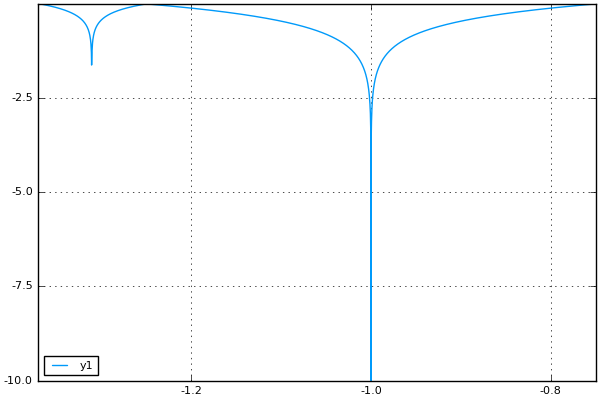

In [9]:
p = plot(c1, map1)

/home/sof9409/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))



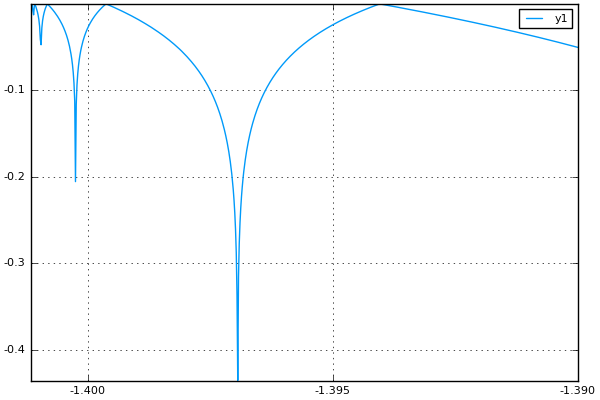

In [10]:
p = plot(c, map)
#plot!(crange,mapeo_liap(crange,Qc,-1.0,10000))

**Ejercicio 2:**

Rehacer los cálculos de los exponentes de Feigenbaum,
\begin{eqnarray*}
f_n &=& \frac{C_n-C_{n+1}}{C_{n+1}-C_{n+2}},\\
a_n &=& \frac{d_n}{d_{n+1}},
\end{eqnarray*}

usando los valores $C_n$ donde se tienen ciclos superestables de periodo $2^n$. (Este ejercicio es muy parecido a los ejercicios 1 y 3 de la `Tarea4`.)

In [15]:
function maxs(map,crange)
    n = length(map)
    c = Float64[]
    for i in 2:n-1
        if (abs(map[i+1]) < abs(map[i]) > abs(map[i-1])) 
            push!(c,(crange[i]))
        end
    end
    c
end

maxs (generic function with 1 method)

In [16]:
cs1 = (vcat(maxs(map1,c1),maxs(map,c)))

6-element Array{Float64,1}:
 -1.0    
 -1.31079
 -1.39694
 -1.40025
 -1.40096
 -1.40111

In [22]:
function newton1D{T<:Real}(f::Function, adiv::T, tol = 1e-10)
    x0 = xdual(adiv)
    fx = f(x0)
    count = 0
    while abs(fx.fun) > tol
        count += 1
        it = x0.fun - fx.fun/fx.der
        x0 = xdual(it)
        fx = f(x0)
        if count == 1000
            break
        end
    end
    return x0.fun
end

Qc(x,c) = x^2 + c

doc"""
    Qcⁿ(x, args)

Esta función define el n-enésimo iterado de $Qc(x,c)$,
donde el valor a iterar es `x` y el valor del parámetro
es `c`, donde `c = args[1]` y `n = args[2]`.
"""
function Qcⁿ(x, args)
    c, n = args[1], args[2]
    @assert n >= 0 && isa(n,Int)
    n <= 1 && return Qc(x,c)
    for it = 1:n
        x = Qc(x,c)
    end
    return x
end

Qcⁿ

In [25]:
function superestables(cs)
    
    for i in 1:length(cs)
        Q4c = c -> Qcⁿ(0.0, (c, 2^i))
        C2 = newton1D(Q4c, cs[i])
        cs[i]=C2
    end
    cs
end

superestables (generic function with 1 method)

In [27]:
superestables(cs1)

6-element Array{Float64,1}:
 -1.0    
 -1.3107 
 -1.38155
 -1.39695
 -1.40025
 -1.40096

In [28]:
feigen(cs1)

4-element Array{Float64,1}:
 4.38568
 4.60095
 4.65513
 4.66611

**Ejercicio 3:**

Comparar gráficamente los mapeos $Q_{c}(x)$ y $Q_{c^\prime}^2(x)$ para $c=1/4, 0, -3/4, -1, -2, -2.2$ y $c^\prime=-3/4,-1,-5/4,-1.3, -1.546\dots, -1.65$. 


**Ejercicio 4:**

Estudiar la dinámica para $c=-2.2$

- ¿Cómo se caracteriza el valor al que tiende *casi* cualquier condición inicial en el
intervalo $I=[-p_+,p_+]$ (donde $p_+$ es el valor positivo tal que $Q_c(p_+)=p_+$), después de muchos iterados? (El intervalo $I$ es donde "toda la dinámica interesante ocurre".)

- ¿Qué condición se requiere, en términos de $I$ (y de los iterados de $Q_c(x)$, para que se cumpla el inciso anterior?

- Caracterizen al complemento del conjunto de los casos anteriores, es decir, cuando los iterados de la condición inicial **no** llegan a donde *casi* cualquier condición inicial termina. ¿Cómo se conoce a este conjunto?

**Ejercicio 5:**

- Usando el análisis gráfico para un valor de $c$ *ligeramente* anterior al punto donde se observa la ventana de periodo 3 para la familia $Q_c(x)$, y uno en la ventana de periodo 3, concluyan el tipo de bifurcación que se observa.

- Comparen la dinámica para ambos valores de $c$ del inciso anterior. ¿Cómo es el exponente de Liapunov en cada caso?

- Encuentren el valor de $c$ donde se da el ciclo superestable de periodo 3. (Nuevamente, ayuden al método de Newton con una buena semilla inicial para $c$.) Demuestren que para este valor de $c$ el mapeo $Q_c^3(x)$ tiene *ocho* puntos fijos, donde dos de ellos son puntos fijos de $Q_c(x)$, y los otros 6 forman dos secuencias periódicas, de periodo 3 en $Q_c(x)$, una de ellas estable y la otra inestable.

(Los siguientes incisos usan el valor de $c$ encontrado en el inciso anterior.)

- Denotando al ciclo inestable de periodo 3 como $\alpha\mapsto \beta\mapsto\gamma$, con $\gamma<\beta<\alpha$, uno puede asociar a cada uno de estos valores un valor $\hat\alpha, \hat\beta, \hat\gamma$, tales que $Q_c^3(\hat\alpha)=\alpha$, $Q_c^3(\hat\beta)=\beta$, $Q_c^3(\hat\gamma)=\gamma$. ¿Qué podemos concluir de un punto que cae en cualquiera de los intervalos $[\alpha,\hat\alpha]$, $[\beta,\hat\beta]$ y $[\hat\gamma,\gamma]$, en términos de los iterados sucesivos?

- Definiendo los intervalos $I_0=[\hat\beta, \alpha]$, $I_1=[\gamma,\beta]$, mostrar que bajo la acción de $Q_c(x)$ se cumple: (i) $Q_c(I_0) \supset I_1$, y (ii) $Q_c(I_1) \supset I_0\cup I_1$. ¿Qué propiedad *importante* de $Q_c(x)$ se utiliza aquí?

(Los intervalos $I_0$ e $I_1$, y estas propiedades, son básicos en la demostración del teorema "periodo tres implica caos".)